In [153]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [154]:
with open("../Names.txt", 'r') as f:
    names = f.read().split('\n')

In [155]:
len(names)

55692

In [156]:
print(np.unique(list(''.join(names))))

[' ' '-' '.' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O'
 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z' 'a' 'b' 'c' 'd' 'e' 'f' 'g'
 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x' 'y'
 'z']


In [157]:
stopchars = [" ","-","."]

In [158]:
names = [name.lower() for name in names if not any(char in stopchars for char in name)]

In [159]:
chars = np.unique(['!']+list(''.join(names)))

In [160]:
char_index = dict()
for char in chars:
    char_index[char] = len(char_index)

In [161]:
window_length = 8
Xs,ys = [],[]
for name in names:
    window = [0]*window_length
    for c in name+'!':
        Xs.append(window)
        ys.append(char_index[c])
        window = window[1:]+[char_index[c]]

In [162]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [163]:
Xs = torch.tensor(Xs, dtype=torch.long, device=device)
ys = torch.tensor(ys, dtype=torch.long, device=device)

In [164]:
for i in range(30):
    print(chars[Xs[i].cpu()], chars[ys[i].cpu()])

['!' '!' '!' '!' '!' '!' '!' '!'] a
['!' '!' '!' '!' '!' '!' '!' 'a'] a
['!' '!' '!' '!' '!' '!' 'a' 'a'] b
['!' '!' '!' '!' '!' 'a' 'a' 'b'] a
['!' '!' '!' '!' 'a' 'a' 'b' 'a'] n
['!' '!' '!' 'a' 'a' 'b' 'a' 'n'] !
['!' '!' '!' '!' '!' '!' '!' '!'] a
['!' '!' '!' '!' '!' '!' '!' 'a'] a
['!' '!' '!' '!' '!' '!' 'a' 'a'] b
['!' '!' '!' '!' '!' 'a' 'a' 'b'] h
['!' '!' '!' '!' 'a' 'a' 'b' 'h'] a
['!' '!' '!' 'a' 'a' 'b' 'h' 'a'] r
['!' '!' 'a' 'a' 'b' 'h' 'a' 'r'] a
['!' 'a' 'a' 'b' 'h' 'a' 'r' 'a'] n
['a' 'a' 'b' 'h' 'a' 'r' 'a' 'n'] !
['!' '!' '!' '!' '!' '!' '!' '!'] a
['!' '!' '!' '!' '!' '!' '!' 'a'] a
['!' '!' '!' '!' '!' '!' 'a' 'a'] b
['!' '!' '!' '!' '!' 'a' 'a' 'b'] h
['!' '!' '!' '!' 'a' 'a' 'b' 'h'] a
['!' '!' '!' 'a' 'a' 'b' 'h' 'a'] s
['!' '!' 'a' 'a' 'b' 'h' 'a' 's'] !
['!' '!' '!' '!' '!' '!' '!' '!'] a
['!' '!' '!' '!' '!' '!' '!' 'a'] a
['!' '!' '!' '!' '!' '!' 'a' 'a'] b
['!' '!' '!' '!' '!' 'a' 'a' 'b'] h
['!' '!' '!' '!' 'a' 'a' 'b' 'h'] a
['!' '!' '!' 'a' 'a' 'b' 'h'

In [165]:
Xs.shape, Xs.dtype, ys.shape, ys.dtype

(torch.Size([494648, 8]), torch.int64, torch.Size([494648]), torch.int64)

In [166]:
class Linear():
    def __init__(self, nins, nouts, bias=True, device="cpu"):
        self.weight = torch.randn((nins, nouts), device=device) / nins**0.5
        self.bias = torch.zeros(nouts, device=device) if bias else None
    def __call__(self,X):
        out = X @ self.weight
        if self.bias is not None:
            out += self.bias
        return out
    def parameters(self):
        return [self.weight] + ([self.bias] if self.bias is not None else [])

class BatchNorm1d():
    def __init__(self, dim, device="cpu", training=True):
        self.gamma = torch.ones((1,dim), device=device)
        self.beta = torch.zeros((1,dim), device=device)
        self.running_mean = torch.zeros((1,dim), device=device)
        self.running_var = torch.ones((1,dim), device=device)
        self.training=training
    def __call__(self, X):
        if self.training:
            mean = X.mean(0, keepdim=True)
            var = X.var(0, keepdim=True)
            self.running_mean = 0.999 * self.running_mean + 0.001 * mean
            self.running_var = 0.999 * self.running_var + 0.001 * var
        else:
            mean = self.running_mean
            var = self.running_var
        return self.gamma * (X - mean) / (var)**0.5 + self.beta
    def setTraining(self, training):
        self.training=training
    def parameters(self):
        return [self.gamma, self.beta]

In [167]:
embedding_dim = 15
hidden_layer = 100
l = window_length*embedding_dim
C = torch.randn((len(chars), embedding_dim), requires_grad=True, device=device)
L1 = Linear(l,hidden_layer,bias=False, device=device)
L2 = Linear(hidden_layer,len(chars), device=device)
B = BatchNorm1d(hidden_layer, device=device, training=False)
parameters = L1.parameters() + L2.parameters() + B.parameters() + [C]
for p in parameters:
    p.requires_grad = True
print(sum(p.nelement() for p in parameters))

15332


In [168]:
lre = np.linspace(-3,0,1000)
lrs = 10**lre

In [169]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xs, ys, test_size=0.1, random_state=42)
X_train,X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [170]:
batch_size=32
exp_rates = []
losses = []
for i in range(1000):
    #minibatch
    batch = torch.randint(0,len(X_train), (batch_size,))
    x_batch=X_train[batch]
    y_batch=y_train[batch]
    # forward pass
    emb = C[x_batch]
    embcat = emb.reshape(-1,l)
    hpreact = L1(embcat)
    hpreact = B(hpreact)
    h = torch.tanh(hpreact)
    logits = L2(h)
    loss = F.cross_entropy(logits, y_batch)
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update parameters
    for p in parameters:
        p.data -= lrs[i] * p.grad
    losses.append(loss.item())
    exp_rates.append(lre[i])

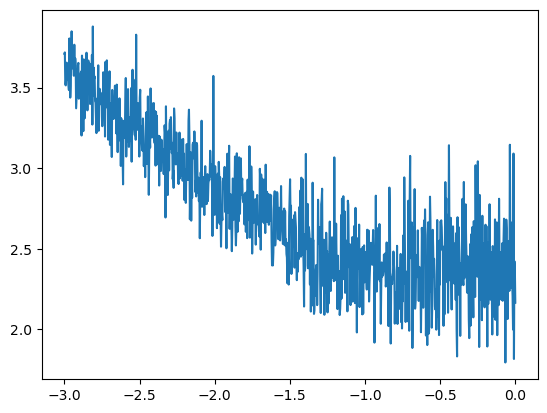

In [171]:
plt.plot(exp_rates,losses)

In [172]:
#10**--1 = 0.1 seems to be a good learning rate
B.setTraining(True)
batch_size=32
losses = []
epochs = 200000
for i in range(epochs):
    #minibatch
    batch = torch.randint(0,len(X_train), (batch_size,))
    x_batch=X_train[batch]
    y_batch=y_train[batch]
    # forward pass
    emb = C[x_batch]
    embcat = emb.reshape(-1,l)
    hpreact = L1(embcat)
    hpreact = B(hpreact)
    h = torch.tanh(hpreact)
    logits = L2(h)
    loss = F.cross_entropy(logits, y_batch)
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update parameters
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad
    # print(loss.item())
    losses.append(loss.item())

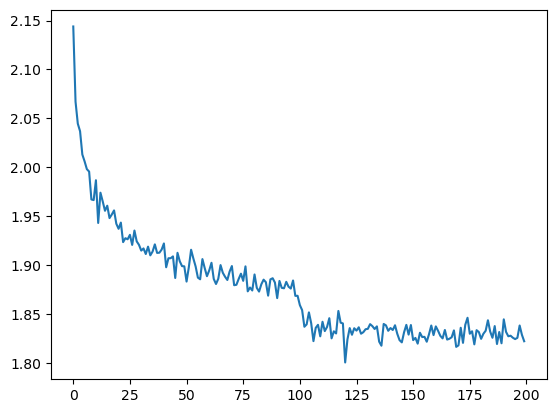

In [173]:
losses = np.array(losses)
plt.plot(losses.reshape(-1,1000).mean(1))

In [174]:
with torch.inference_mode():
    B.setTraining(False)
    emb = C[X_train]
    embcat = emb.reshape(-1,l)
    hpreact = L1(embcat)
    hpreact = B(hpreact)
    h = torch.tanh(hpreact)
    logits = L2(h)
    train_loss = F.cross_entropy(logits, y_train)
    emb = C[X_val]
    embcat = emb.reshape(-1,l)
    hpreact = L1(embcat)
    hpreact = B(hpreact)
    h = torch.tanh(hpreact)
    logits = L2(h)
    val_loss = F.cross_entropy(logits, y_val)
    print(f'Train loss: {train_loss.item()}, Val loss: {val_loss.item()}')

Train loss: 1.801205039024353, Val loss: 1.8342100381851196


In [175]:
import pickle
torch.save(C, 'params/C.pt')
torch.save(L1.weight, 'params/W1.pt')
torch.save(L2.weight, 'params/W2.pt')
torch.save(L2.bias, 'params/b2.pt')
torch.save(B.gamma, 'params/bngain.pt')
torch.save(B.beta, 'params/bnbias.pt')
torch.save(B.running_mean, 'params/bnmean.pt')
torch.save(B.running_var, 'params/bnvar.pt')
with open('params/chars.pkl', 'wb') as f:
    pickle.dump(chars, f)
with open('params/char_index.pkl', 'wb') as f:
    pickle.dump(char_index, f)